# 50K Project - Classification

### Joseph Harvey, July 2021

In this analysis, I aim to predict whether a person makes more or less than $50k based on a variety of factors, including education, age, and marital status, among others.

In [272]:
#import needed classes
import pandas as pd
#suppressing a pandas future warning
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import minmax_scale

## 1. Importing the Data and Cleaning Up Features

We begin by importing our training and testing sets as pandas dataframes. Taking a glimpse at the testing data .csv file in Excel, we notice that, in the class column, there is an unwanted period after each entry. We also notice, in both files, that some entries have '?' where a column entry is unknown. So, let's remove all rows with a '?' in them and trim those periods from the 'class' column in the test data.

In [283]:
df_train = pd.read_csv('au_train.csv', skipinitialspace = True)
df_test = pd.read_csv('au_test.csv', skipinitialspace = True)

#Remove all entries with '?'
indices_to_drop = np.where(df_train =='?')[0]
df_train = df_train.drop(indices_to_drop)

indices_to_drop = np.where(df_test =='?')[0]
df_test = df_test.drop(indices_to_drop)

#Remove '.' from '<=50K.' and '>50K.' in testing data
df_test = df_test.replace('<=50K.', '<=50K')
df_test = df_test.replace('>50K.', '>50K')

Let's simplify some of the features in this dataset. We reduce the number of classes within education to 'Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', and 'Doctorate'. That is, we lump everything together that is prior to high school graduation, and we'll combine the two types of Associate degree. This will hopefully improve performance in our logistic regression. 

We also clean up the marital-status feature by combining 'Married-civ-spouse' and 'Married-AF-spouse' into one 'Married' category.

In [274]:
#Simplifying education in training set
df_train['education']=np.where(df_train['education'] =='Preschool', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='1st-4th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='5th-6th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='7th-8th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='9th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='10th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='11th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='12th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-voc', 'Assoc', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-acdm', 'Assoc', df_train['education'])

#Simplifying education in testing set
df_test['education']=np.where(df_test['education'] =='Preschool', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='1st-4th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='5th-6th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='7th-8th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='9th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='10th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='11th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='12th', 'Pre-HS-grad', df_test['education'])
df_test['education']=np.where(df_test['education'] =='Assoc-voc', 'Assoc', df_test['education'])
df_test['education']=np.where(df_test['education'] =='Assoc-acdm', 'Assoc', df_test['education'])

#Simplifying marital-status
df_train = df_train.replace('Married-civ-spouse', 'Married')
df_train = df_train.replace('Married-AF-spouse', 'Married')
df_test = df_test.replace('Married-civ-spouse', 'Married')
df_test = df_test.replace('Married-AF-spouse', 'Married')

## 2. Logistic Regression Model

Given that this is a binary classification task, let's try a binary logistic regression model. 

Let's select only a subset of the features in the training set, choosing what we think will be valuable for the model and eliminating features which are obviously highly correlated (e.g., marital status and relationship). Here, we choose only the 'age', 'marital-status', 'education', and 'hours-per-week' features.

We create our dummy variables and train the logistic regression model. For the logistic regression, we count a '>50K' class as a 1, and '<=50K' as 0.

In [275]:
#selecting desired columns
df_train_small = df_train[['age','hours-per-week', 'marital-status', 'education','class']]
df_test_small = df_test[['age', 'hours-per-week', 'marital-status', 'education', 'class']]

#scale numerical variables
df_train_small.loc[:, 'age'] = minmax_scale(df_train_small['age'])
df_train_small.loc[:, 'hours-per-week'] = minmax_scale(df_train_small['hours-per-week'])

df_test_small.loc[:, 'age'] = minmax_scale(df_test_small['age'])
df_test_small.loc[:, 'hours-per-week'] = minmax_scale(df_test_small['hours-per-week'])

#create dummies
df_train_dummies = pd.get_dummies(df_train_small)
df_test_dummies = pd.get_dummies(df_test_small)

#separate dependent and independent variables
df_train_X = df_train_dummies.drop(['class_<=50K', 'class_>50K'], axis=1)
df_train_y = df_train_dummies['class_>50K']

df_test_X = df_test_dummies.drop(['class_<=50K', 'class_>50K'], axis=1)
df_test_y = df_test_dummies['class_>50K']

#create logistic regression model using the liblinear solver (I tried a couple different solvers, and this one
#allows the model to converge)
logreg = LogisticRegression(solver = 'liblinear')

#train the model and get predictions based on the testing data
logreg.fit(df_train_X, df_train_y)
df_pred_y = logreg.predict(df_test_X)

It seems that the model was trained successfully. Let's test it and evaluate the results.

## 3. Evaluating the Performance of the Logistic Regression Model

Let's get the confusion matrix and accuracy score for our logistic regression model.

Log Regression Accuracy: 0.8154050464807437


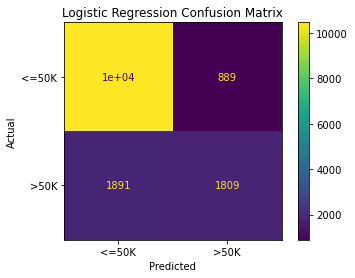

In [276]:
#confusion matrix
cm = confusion_matrix(df_test_y, df_pred_y)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Logistic Regression Confusion Matrix', 
                xlabel='Predicted', 
                ylabel='Actual')
print('Log Regression Accuracy: ' + str(accuracy_score(df_test_y, df_pred_y)))

Looking at the confusion matrix, our model does well at correctly predicting <=50K cases; when a datapoint is <=50K, it classifies it with an accuracy of 11360/(11360+889) = 0.93. It does significantly worse with >50K cases, as expected, with an accuracy of 1809/(1809+1891) = 0.49 for those cases. Improving this model should focus on reducing the misclassifications of >50K cases. 

Based on this confusion matrix, the overall accuracy of the logistic regression model is 0.815. Let's compare this to a naive classifier which always predicts <=50K, the majority class.

In [277]:
#find how many of each class are in the testing set
df_test['class'].value_counts()

<=50K    11360
>50K      3700
Name: class, dtype: int64

A naive classifier which always guesses <=50K would have an accuracy of 11360/(11360+3700) = 0.75. So, we see that our logistic regression model does better than a naive classifier, but clearly there's still room for improvement here.

Now let's generate the ROC curve and AUC score for this logistic regression model.

AUC: 0.8703074324324325


Text(0, 0.5, 'True Positive Rate')

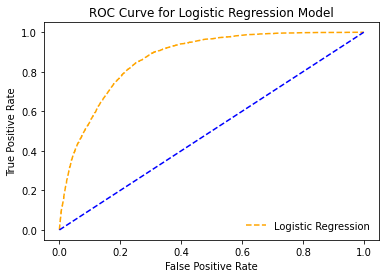

In [278]:
#get ROC for logreg model
pred_prob = logreg.predict_proba(df_test_X)
fpr, tpr, thresh = roc_curve(df_test_y, pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(df_test_y))]
p_fpr, p_tpr, _ = roc_curve(df_test_y, random_probs, pos_label=1)

auc_score = roc_auc_score(df_test_y, pred_prob[:,1])
print('AUC: ' + str(auc_score))

plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label = 'Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.legend(loc='best')

# title
plt.title('ROC Curve for Logistic Regression Model')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

So, our logistic regression model has an AUC of 0.87. A random classifier has an AUC of 0.5, so this classifier is doing much better than random guessing.

Finally, let's try to gain some insight into which features were valuable for the logistic regression in predicting income class. The .coef_ attribute of the LogisticRegression model gives an indication of how strongly correlated each feature is with income class.

Text(0.5, 0, 'feature name')

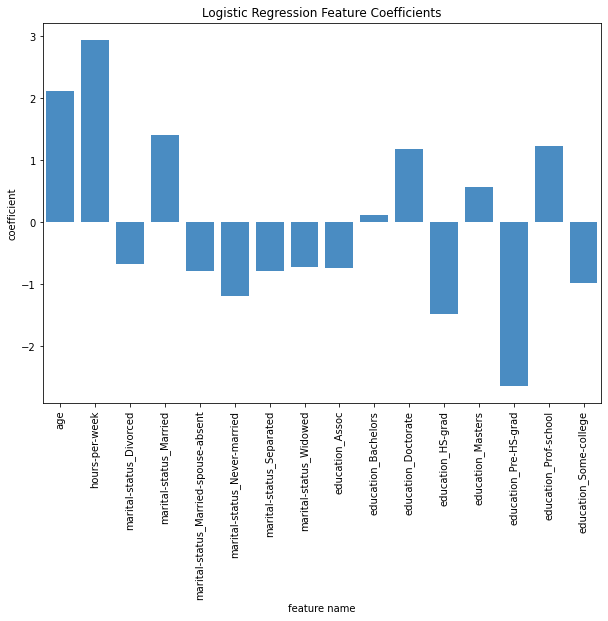

In [279]:
#coeff plot
coeffs = logreg.coef_[0]

log_features = pd.DataFrame({'feature_name': df_train_X.columns.values,
                            'coeff': coeffs})

fig, ax = plt.subplots(figsize=(10,7))
bars = sns.barplot(x= log_features['feature_name'], y= log_features['coeff'], color = '#368ed6')
for item in bars.get_xticklabels():
    item.set_rotation(90)
plt.title('Logistic Regression Feature Coefficients')
plt.ylabel('coefficient')
plt.xlabel('feature name')

On this plot, highly positive coefficients are strongly correlated with the >50K class; as expected, the 'age' and 'hours-per-week' coefficents are very positive. The 'Married' feature is also strongly correlated with >50K, as suggested by our segmentation study. Meanwhile, 'Pre-HS-grad' is the feature most strongly correlated with the <=50K class. Note that most features had negative coefficients in the logistic regression. Work to improve this model could include finding more features which have positive coefficients. We might expect that this would improve classification of >50K cases.

## 4. Random Forest Classifier

Let's see if we can't beat the performance of our logistic regression model with a random forest classifier. We'll use exactly the same data that we used to train the logistic regression model.

Random Forest Classifier Accuracy: 0.8228419654714475


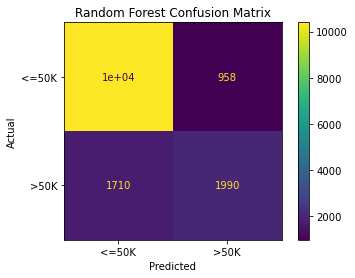

In [280]:
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(df_train_X, df_train_y)

pred_y = rfc.predict(df_test_X)

#confusion matrix
cm = confusion_matrix(df_test_y, pred_y)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Random Forest Confusion Matrix', 
                xlabel='Predicted', 
                ylabel='Actual')
print("Random Forest Classifier Accuracy: " + str(accuracy_score(df_test_y, pred_y)))

Our random forest classifier, with an accuracy of 0.823, edges out our logistic regression model. The improvement largely comes from more accurately classifying instances of the >50K class, with 0.54 accuracy for that class. Let's plot the ROC curves for both models together to see how they compare.

AUC: 0.8760897054625049


Text(0, 0.5, 'True Positive Rate')

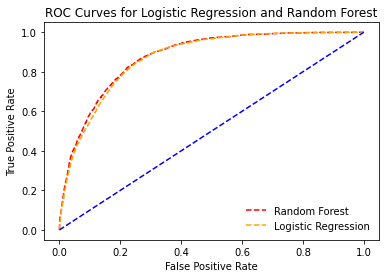

In [281]:
#get ROC for logreg model
rf_pred_prob = rfc.predict_proba(df_test_X)
rf_fpr, rf_tpr, rf_thresh = roc_curve(df_test_y, rf_pred_prob[:,1], pos_label=1)

auc_score_rf = roc_auc_score(df_test_y, rf_pred_prob[:,1])
print("AUC: " + str(auc_score_rf))

plt.plot(rf_fpr, rf_tpr, linestyle = '--', color = 'red', label = 'Random Forest')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label = 'Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.legend(loc='best')

# title
plt.title('ROC Curves for Logistic Regression and Random Forest')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

Comparing the ROC curves, as well as AUC scores, confirms that the random forest classifier does a slightly better job at predicting income class than the logistic regression model. The random forest has an AUC of 0.88 vs. 0.87 for the logistic regression. The plot with the two curves together suggests that at some threshold values, the random forest has a slight edge on the logistic regression.

## 5. Paths to Improvement

Although the classes in the training set, at about a 3:1 ratio, are somewhat imbalanced, this is probably not enough of an imbalance to cause great concern, and the random forest classifier sees decent accuracy without any effort to balance the classes. Further work could be done to balance the classes for training while ensuring that the model performs well on test data with unbalanced <=50K and >50K classes.

Additionally, we could be a little more scientific about selecting the features to train on. Here, we use an approach which uses data visualization and exploration from the segmentation study, as well as intuition, to inform an intelligent guess as to which features are valuable, and this yields decent results. The models could be further optimized by using a more sophisticated method to ensure the most valuable features are chosen and to increase feature independence.